In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
bank_data = pd.read_csv (r"C:\Users\aishw\OneDrive\Desktop\bank_transactions_data_2.csv")
print(bank_data.info())
print(bank_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

Estimated Agreement Rate (IF & LOF): 93.87%
Fraudulent Transactions (IF): 126
Fraudulent Transactions (LOF): 126
Fraudulent Transactions (Ensemble): 49
Number of Intersecting Anomalies (IF & LOF): 49


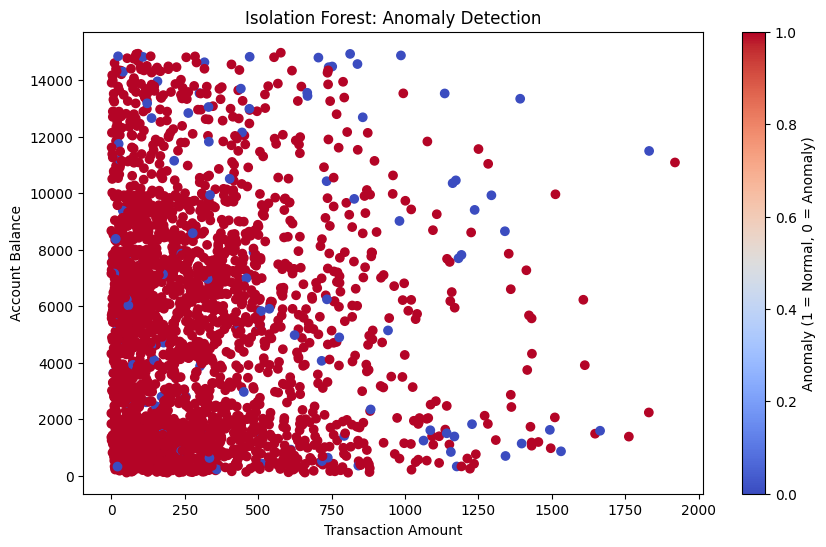

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, LabelEncoder


bank_data = pd.read_csv(r"C:\Users\aishw\OneDrive\Desktop\bank_transactions_data_2.csv")

numeric_columns = ['TransactionAmount', 'AccountBalance', 'LoginAttempts', 'CustomerAge', 'TransactionDuration']

for col in numeric_columns:
    bank_data[col] = pd.to_numeric(bank_data[col], errors='coerce').fillna(0).astype(int)

categorical_columns = ['TransactionType', 'Location', 'DeviceID', 'IP Address', 'Channel', 'AccountID', 'TransactionID']
label_encoder = LabelEncoder()
for col in categorical_columns:
    bank_data[col] = label_encoder.fit_transform(bank_data[col].astype(str))


features = numeric_columns + categorical_columns
X = bank_data[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


if_model = IsolationForest(contamination=0.05, random_state=42)
bank_data['Anomaly_IF'] = if_model.fit_predict(X_scaled)
bank_data['Anomaly_IF'] = bank_data['Anomaly_IF'].apply(lambda x: 1 if x == 1 else 0)  

lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
bank_data['Anomaly_LOF'] = lof_model.fit_predict(X_scaled)
bank_data['Anomaly_LOF'] = bank_data['Anomaly_LOF'].apply(lambda x: 1 if x == 1 else 0)  

bank_data['Anomaly_Ensemble'] = (bank_data['Anomaly_IF'] + bank_data['Anomaly_LOF']) >= 1
bank_data['Anomaly_Ensemble'] = bank_data['Anomaly_Ensemble'].astype(int)

intersection_count = sum((bank_data['Anomaly_IF'] == 0) & (bank_data['Anomaly_LOF'] == 0))

accuracy_percentage = np.mean(bank_data['Anomaly_IF'] == bank_data['Anomaly_LOF']) * 100

fraud_count_if = sum(bank_data['Anomaly_IF'] == 0)
fraud_count_lof = sum(bank_data['Anomaly_LOF'] == 0)
fraud_count_ensemble = sum(bank_data['Anomaly_Ensemble'] == 0)

print(f"Estimated Agreement Rate (IF & LOF): {accuracy_percentage:.2f}%")
print(f"Fraudulent Transactions (IF): {fraud_count_if}")
print(f"Fraudulent Transactions (LOF): {fraud_count_lof}")
print(f"Fraudulent Transactions (Ensemble): {fraud_count_ensemble}")
print(f"Number of Intersecting Anomalies (IF & LOF): {intersection_count}")

plt.figure(figsize=(10, 6))
plt.scatter(bank_data['TransactionAmount'], bank_data['AccountBalance'], c=bank_data['Anomaly_IF'], cmap='coolwarm', marker='o')
plt.title("Isolation Forest: Anomaly Detection")
plt.xlabel("Transaction Amount")
plt.ylabel("Account Balance")
plt.colorbar(label="Anomaly (1 = Normal, 0 = Anomaly)")
plt.show()


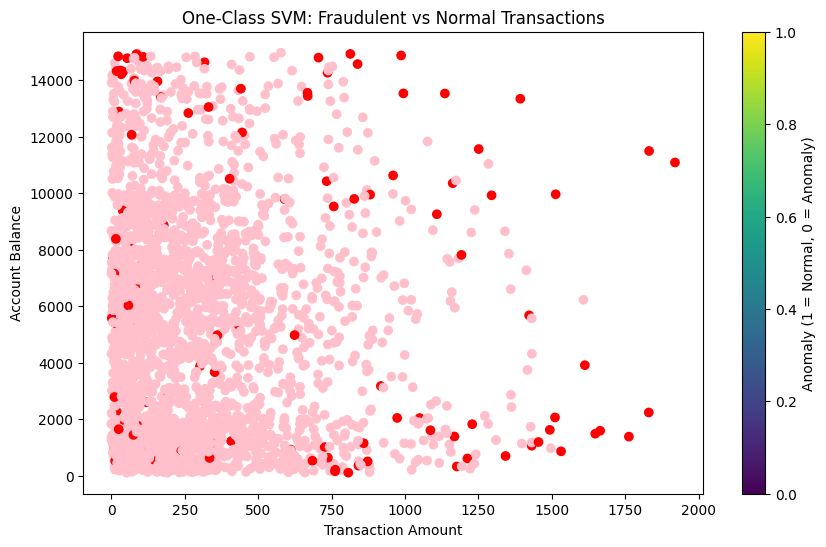

Anomalies detected: 130
Normal transactions: 2382
    TransactionID AccountID  TransactionAmount      TransactionDate  \
26       TX000027   AC00441             246.93  2023-04-17 16:37:01   
41       TX000042   AC00480              34.02  2023-01-09 16:13:21   
61       TX000062   AC00002             263.99  2023-05-16 16:07:30   
74       TX000075   AC00265            1212.51  2023-10-04 16:36:29   
141      TX000142   AC00114            1049.92  2023-10-23 16:50:33   

    TransactionType      Location DeviceID       IP Address MerchantID  \
26            Debit         Miami  D000046   55.154.161.250       M029   
41            Debit  Philadelphia  D000627  109.105.179.186       M046   
61            Debit        Dallas  D000285     7.146.35.122       M087   
74            Debit  Indianapolis  D000231     193.83.0.183       M036   
141           Debit       Detroit  D000522    121.67.144.20       M052   

    Channel  CustomerAge CustomerOccupation  TransactionDuration  \
26      AT

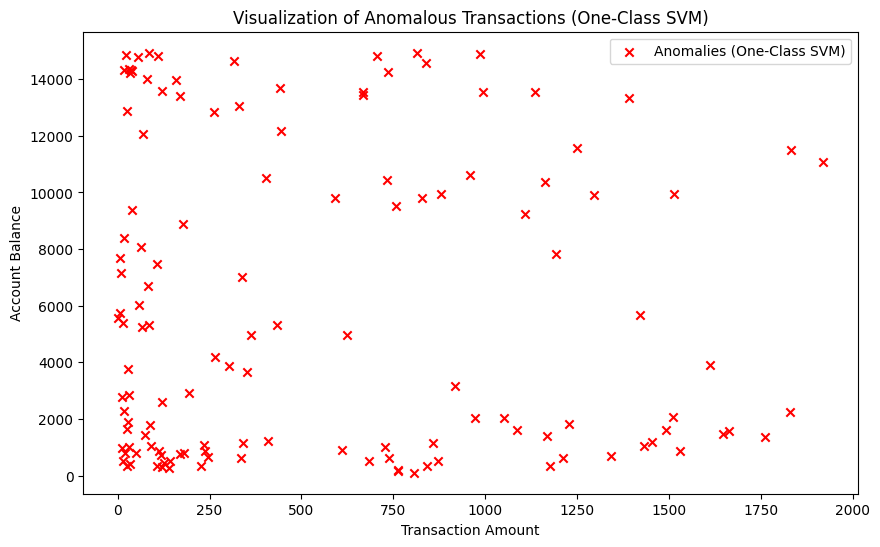

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler


bank_data = pd.read_csv(r"C:\Users\aishw\OneDrive\Desktop\bank_transactions_data_2.csv")

X = bank_data.select_dtypes(include=[np.number])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize One-Class SVM for anomaly detection
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale") 
ocsvm.fit(X_scaled)

y_pred = ocsvm.predict(X_scaled)

bank_data['Anomaly_OCSVM'] = [1 if i == 1 else 0 for i in y_pred]

plt.figure(figsize=(10, 6))
plt.scatter(bank_data['TransactionAmount'], bank_data['AccountBalance'], 
            c=bank_data['Anomaly_OCSVM'].map({1: 'pink', 0: 'red'}), marker='o')
plt.title("One-Class SVM: Fraudulent vs Normal Transactions")
plt.xlabel("Transaction Amount")
plt.ylabel("Account Balance")
plt.colorbar(label="Anomaly (1 = Normal, 0 = Anomaly)")
plt.show()

print(f"Anomalies detected: {sum(bank_data['Anomaly_OCSVM'] == 0)}")
print(f"Normal transactions: {sum(bank_data['Anomaly_OCSVM'] == 1)}")

print(bank_data[bank_data['Anomaly_OCSVM'] == 0].head())

anomalies = bank_data[bank_data['Anomaly_OCSVM'] == 0]
anomalies.to_csv("anomalous_transactions_OCSVM.csv", index=False)
print("Anomalous transactions saved successfully!")

plt.figure(figsize=(10, 6))
plt.scatter(anomalies['TransactionAmount'], anomalies['AccountBalance'], 
            color='red', marker='x', label="Anomalies (One-Class SVM)")
plt.title("Visualization of Anomalous Transactions (One-Class SVM)")
plt.xlabel("Transaction Amount")
plt.ylabel("Account Balance")
plt.legend()
plt.show()


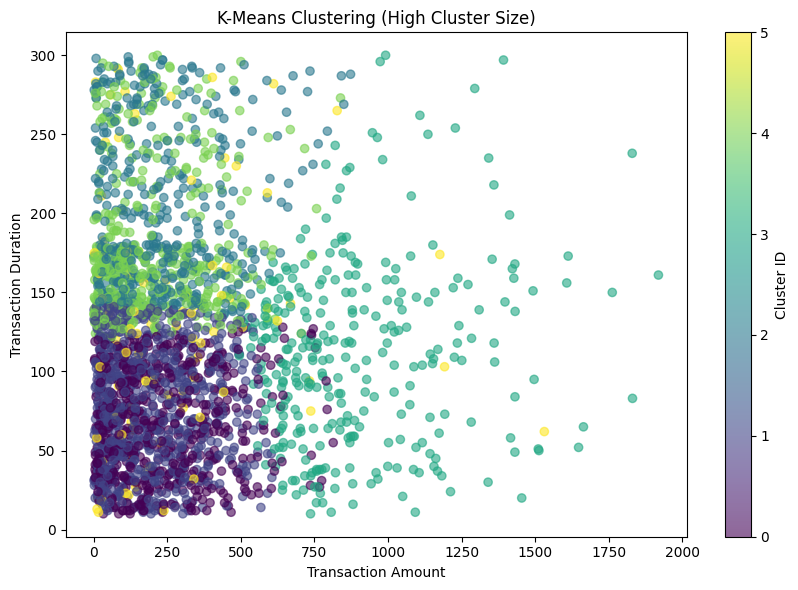

Optimal K for K-Means (Manually Set): 6
Fraudulent Transactions (IF): 126
Fraudulent Transactions (LOF): 126
Fraudulent Transactions (K-Means): 95
Fraudulent Transactions (OC-SVM): 128
Fraudulent Transactions (Majority Voting): 80
Fraudulent Transactions (Intersection): 247
Estimated Accuracy (Agreement Rate): 95.08%
Estimated Accuracy (Intersection Method): 90.17%


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

bank_data = pd.read_csv(r"C:\Users\aishw\OneDrive\Desktop\bank_transactions_data_2.csv")

features = ['TransactionAmount', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
X = bank_data[features]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
bank_data['Anomaly_IF'] = iso_forest.fit_predict(X_scaled)
bank_data['Anomaly_IF'] = bank_data['Anomaly_IF'].apply(lambda x: 1 if x == 1 else 0)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred_lof = lof.fit_predict(X_scaled)
bank_data['Anomaly_LOF'] = np.where(y_pred_lof == -1, 0, 1)

X_kmeans = X_scaled 

inertia_scores = []
k_range = range(2, 21)  # Increased max cluster size
for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=500, random_state=42)
    kmeans.fit(X_kmeans)
    inertia_scores.append(kmeans.inertia_)

optimal_k = 6  
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=500, random_state=42)
bank_data['Cluster'] = kmeans.fit_predict(X_kmeans)

# Identifying the smallest cluster as potential fraud
smallest_cluster = bank_data['Cluster'].value_counts().idxmin()
bank_data['Anomaly_KMeans'] = np.where(bank_data['Cluster'] == smallest_cluster, 0, 1)

oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
bank_data['Anomaly_OCSVM'] = oc_svm.fit_predict(X_scaled)
bank_data['Anomaly_OCSVM'] = np.where(bank_data['Anomaly_OCSVM'] == -1, 0, 1)

bank_data['Anomaly_MajorityVoting'] = (
    (bank_data['Anomaly_IF'] + bank_data['Anomaly_LOF'] + bank_data['Anomaly_KMeans'] + bank_data['Anomaly_OCSVM']) >= 2
).astype(int)

agreement_if_lof = np.mean(bank_data['Anomaly_IF'] == bank_data['Anomaly_LOF']) * 100
agreement_if_kmeans = np.mean(bank_data['Anomaly_IF'] == bank_data['Anomaly_KMeans']) * 100
agreement_lof_kmeans = np.mean(bank_data['Anomaly_LOF'] == bank_data['Anomaly_KMeans']) * 100
agreement_ocsvm_if = np.mean(bank_data['Anomaly_OCSVM'] == bank_data['Anomaly_IF']) * 100

accuracy_agreement = (agreement_if_lof + agreement_if_kmeans + agreement_lof_kmeans + agreement_ocsvm_if) / 4

bank_data['Anomaly_Intersection'] = (
    (bank_data['Anomaly_IF'] & bank_data['Anomaly_LOF'] & bank_data['Anomaly_KMeans'] & bank_data['Anomaly_OCSVM'])
)

accuracy_intersection = np.mean(bank_data['Anomaly_Intersection'] == 1) * 100

plt.figure(figsize=(25, 6))

fraud_counts = [
    sum(bank_data['Anomaly_IF'] == 0),
    sum(bank_data['Anomaly_LOF'] == 0),
    sum(bank_data['Anomaly_KMeans'] == 0),
    sum(bank_data['Anomaly_OCSVM'] == 0),
    sum(bank_data['Anomaly_MajorityVoting'] == 0),
    sum(bank_data['Anomaly_Intersection'] == 0)
]
labels = ['IF', 'LOF', 'K-Means', 'OC-SVM', 'Majority Voting', 'Intersection']

plt.subplot(1, 3, 3)
plt.scatter(bank_data['TransactionAmount'], bank_data['TransactionDuration'], c=bank_data['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Duration')
plt.title('K-Means Clustering (High Cluster Size)')
plt.colorbar(label='Cluster ID')

plt.tight_layout()
plt.show()
print(f"Optimal K for K-Means (Manually Set): {optimal_k}")
print(f"Fraudulent Transactions (IF): {fraud_counts[0]}")
print(f"Fraudulent Transactions (LOF): {fraud_counts[1]}")
print(f"Fraudulent Transactions (K-Means): {fraud_counts[2]}")
print(f"Fraudulent Transactions (OC-SVM): {fraud_counts[3]}")
print(f"Fraudulent Transactions (Majority Voting): {fraud_counts[4]}")
print(f"Fraudulent Transactions (Intersection): {fraud_counts[5]}")
print(f"Estimated Accuracy (Agreement Rate): {accuracy_agreement:.2f}%")
print(f"Estimated Accuracy (Intersection Method): {accuracy_intersection:.2f}%")

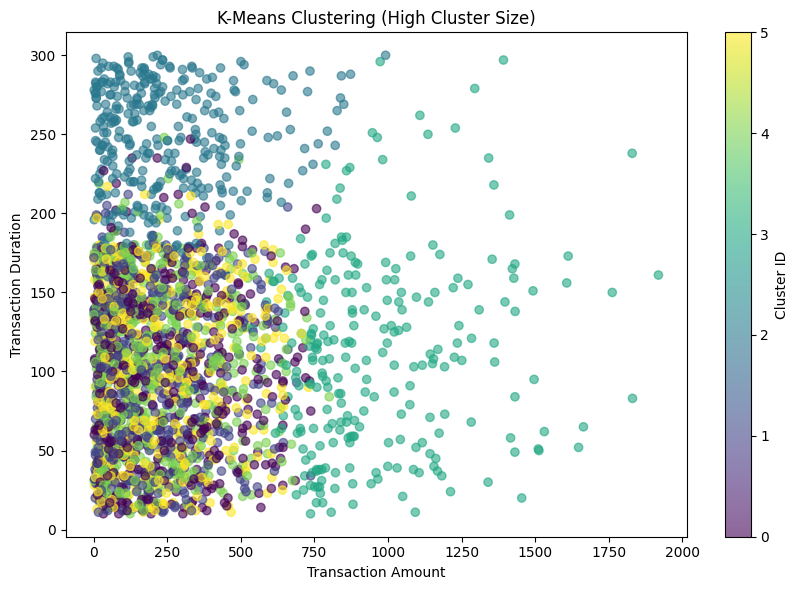

Optimal K for K-Means (Manually Set): 6
Fraudulent Transactions (IF): 126
Fraudulent Transactions (LOF): 126
Fraudulent Transactions (K-Means): 252
Fraudulent Transactions (OC-SVM): 129
Fraudulent Transactions (Majority Voting): 79
Estimated Accuracy (Agreement Rate): 93.16%
Estimated Accuracy (Intersection Method): 84.67%
Total Accuracy: 85.91%


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer


bank_data = pd.read_csv(r"C:\Users\aishw\OneDrive\Desktop\bank_transactions_data_2.csv")
bank_data['PreviousTransactionDate'] = pd.to_datetime(bank_data['PreviousTransactionDate'])
bank_data['TransactionDate'] = pd.to_datetime(bank_data['TransactionDate'])

# ✅ Compute time difference in hours
bank_data['Time_Diff_Hours'] = (bank_data['TransactionDate'] - bank_data['PreviousTransactionDate']).dt.total_seconds() / 3600

label_encoders = {}
for col in ['Location', 'IP Address', 'AccountID', 'MerchantID', 'DeviceID']:
    le = LabelEncoder()
    bank_data[col] = le.fit_transform(bank_data[col].astype(str))
    label_encoders[col] = le  

features = ['TransactionAmount', 'TransactionDuration' , 'Location', 'IP Address', 'Time_Diff_Hours', 'AccountID' , 'DeviceID' ]
X = bank_data[features]

imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(contamination=0.05, random_state=42)
bank_data['Anomaly_IF'] = iso_forest.fit_predict(X_scaled)
bank_data['Anomaly_IF'] = bank_data['Anomaly_IF'].apply(lambda x: 1 if x == 1 else 0)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred_lof = lof.fit_predict(X_scaled)
bank_data['Anomaly_LOF'] = np.where(y_pred_lof == -1, 0, 1)

optimal_k = 6  
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=500, random_state=42)
bank_data['Cluster'] = kmeans.fit_predict(X_scaled)

smallest_cluster = bank_data['Cluster'].value_counts().idxmin()
bank_data['Anomaly_KMeans'] = np.where(bank_data['Cluster'] == smallest_cluster, 0, 1)

oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
bank_data['Anomaly_OCSVM'] = oc_svm.fit_predict(X_scaled)
bank_data['Anomaly_OCSVM'] = np.where(bank_data['Anomaly_OCSVM'] == -1, 0, 1)

bank_data['Anomaly_MajorityVoting'] = (
    (bank_data['Anomaly_IF'] + bank_data['Anomaly_LOF'] + bank_data['Anomaly_KMeans'] + bank_data['Anomaly_OCSVM']) >= 2
).astype(int)

agreement_if_lof = np.mean(bank_data['Anomaly_IF'] == bank_data['Anomaly_LOF']) * 100
agreement_if_kmeans = np.mean(bank_data['Anomaly_IF'] == bank_data['Anomaly_KMeans']) * 100
agreement_lof_kmeans = np.mean(bank_data['Anomaly_LOF'] == bank_data['Anomaly_KMeans']) * 100
agreement_ocsvm_if = np.mean(bank_data['Anomaly_OCSVM'] == bank_data['Anomaly_IF']) * 100

accuracy_agreement = (agreement_if_lof + agreement_if_kmeans + agreement_lof_kmeans + agreement_ocsvm_if) / 4

bank_data['Anomaly_Intersection'] = (
    (bank_data['Anomaly_IF'] & bank_data['Anomaly_LOF'] & bank_data['Anomaly_KMeans'] & bank_data['Anomaly_OCSVM'])
)

accuracy_intersection = np.mean(bank_data['Anomaly_Intersection'] == 1) * 100

total_transactions = len(bank_data)
total_agreement = sum(
    (bank_data['Anomaly_IF'] == bank_data['Anomaly_LOF']) &
    (bank_data['Anomaly_IF'] == bank_data['Anomaly_KMeans']) &
    (bank_data['Anomaly_IF'] == bank_data['Anomaly_OCSVM'])
)

total_accuracy = (total_agreement / total_transactions) * 100

plt.figure(figsize=(25, 6))

fraud_counts = [
    sum(bank_data['Anomaly_IF'] == 0),
    sum(bank_data['Anomaly_LOF'] == 0),
    sum(bank_data['Anomaly_KMeans'] == 0),
    sum(bank_data['Anomaly_OCSVM'] == 0),
    sum(bank_data['Anomaly_MajorityVoting'] == 0),
    sum(bank_data['Anomaly_Intersection'] == 0)
]
labels = ['IF', 'LOF', 'K-Means', 'OC-SVM', 'Majority Voting', 'Intersection']

plt.subplot(1, 3, 3)
plt.scatter(bank_data['TransactionAmount'], bank_data['TransactionDuration'], c=bank_data['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Duration')
plt.title('K-Means Clustering (High Cluster Size)')
plt.colorbar(label='Cluster ID')

plt.tight_layout()
plt.show()

print(f"Optimal K for K-Means (Manually Set): {optimal_k}")
print(f"Fraudulent Transactions (IF): {fraud_counts[0]}")
print(f"Fraudulent Transactions (LOF): {fraud_counts[1]}")
print(f"Fraudulent Transactions (K-Means): {fraud_counts[2]}")
print(f"Fraudulent Transactions (OC-SVM): {fraud_counts[3]}")
print(f"Fraudulent Transactions (Majority Voting): {fraud_counts[4]}")
#print(f"Fraudulent Transactions (Intersection): {fraud_counts[5]}")
print(f"Estimated Accuracy (Agreement Rate): {accuracy_agreement:.2f}%")
print(f"Estimated Accuracy (Intersection Method): {accuracy_intersection:.2f}%")
print(f"Total Accuracy: {total_accuracy:.2f}%")


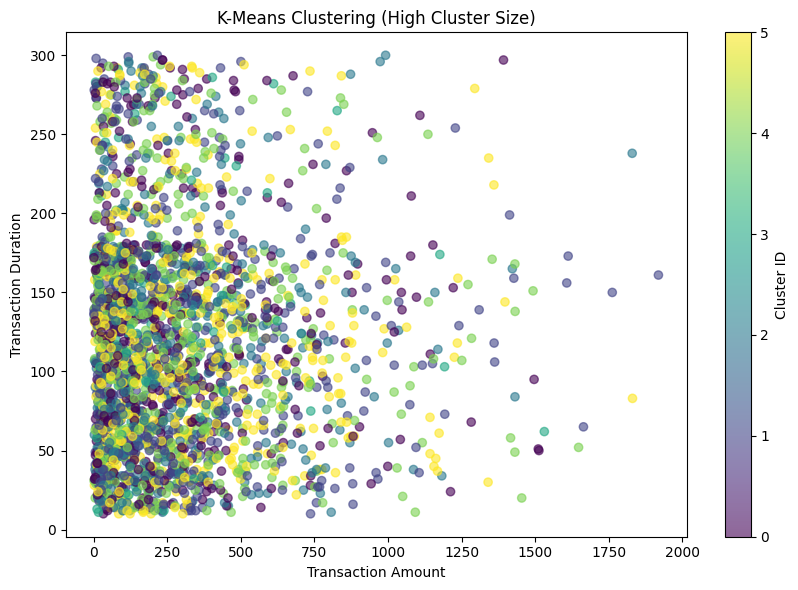

Optimal K for K-Means: 6
Fraudulent Transactions (IF): 126
Fraudulent Transactions (LOF): 126
Fraudulent Transactions (K-Means): 95
Fraudulent Transactions (OC-SVM): 130
Fraudulent Transactions (Majority Voting): 67
Estimated Accuracy (Agreement Rate): 94.77%
Estimated Accuracy (Intersection Method): 90.01%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

 
bank_data = pd.read_csv(r"C:\Users\aishw\OneDrive\Desktop\bank_transactions_data_2.csv")

features = [ 'Channel' ,'IP Address', 'DeviceID', 'Location', 'TransactionType', 'AccountID', 'LoginAttempts', ] 
label_encoders = {}
categorical_features = ['IP Address', 'DeviceID', 'Location', 'TransactionType' , 'Channel', 'AccountID']

for col in categorical_features:
    le = LabelEncoder()
    bank_data[col] = le.fit_transform(bank_data[col].astype(str))
    label_encoders[col] = le  # Store encoder for reference

# ✅ Handle Missing Values
imputer = SimpleImputer(strategy='most_frequent')  
X = imputer.fit_transform(bank_data[features])

# ✅ Standardize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### 🚀 Step 1: Anomaly Detection Using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
bank_data['Anomaly_IF'] = iso_forest.fit_predict(X_scaled)
bank_data['Anomaly_IF'] = np.where(bank_data['Anomaly_IF'] == -1, 0, 1)


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
bank_data['Anomaly_LOF'] = np.where(lof.fit_predict(X_scaled) == -1, 0, 1)

optimal_k = 6  # Manually Set
kmeans = KMeans(n_clusters=optimal_k, n_init=10, max_iter=500, random_state=42)
bank_data['Cluster'] = kmeans.fit_predict(X_scaled)

smallest_cluster = bank_data['Cluster'].value_counts().idxmin()
bank_data['Anomaly_KMeans'] = np.where(bank_data['Cluster'] == smallest_cluster, 0, 1)

oc_svm = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
bank_data['Anomaly_OCSVM'] = np.where(oc_svm.fit_predict(X_scaled) == -1, 0, 1)

bank_data['Anomaly_MajorityVoting'] = (
    (bank_data['Anomaly_IF'] + bank_data['Anomaly_LOF'] + bank_data['Anomaly_KMeans'] + bank_data['Anomaly_OCSVM']) >= 2
).astype(int)

agreement_if_lof = np.mean(bank_data['Anomaly_IF'] == bank_data['Anomaly_LOF']) * 100
agreement_if_kmeans = np.mean(bank_data['Anomaly_IF'] == bank_data['Anomaly_KMeans']) * 100
agreement_lof_kmeans = np.mean(bank_data['Anomaly_LOF'] == bank_data['Anomaly_KMeans']) * 100
agreement_ocsvm_if = np.mean(bank_data['Anomaly_OCSVM'] == bank_data['Anomaly_IF']) * 100

accuracy_agreement = (agreement_if_lof + agreement_if_kmeans + agreement_lof_kmeans + agreement_ocsvm_if) / 4

bank_data['Anomaly_Intersection'] = (
    (bank_data['Anomaly_IF'] & bank_data['Anomaly_LOF'] & bank_data['Anomaly_KMeans'] & bank_data['Anomaly_OCSVM'])
)

accuracy_intersection = np.mean(bank_data['Anomaly_Intersection'] == 1) * 100
plt.figure(figsize=(25, 6))
fraud_counts = [
    sum(bank_data['Anomaly_IF'] == 0),
    sum(bank_data['Anomaly_LOF'] == 0),
    sum(bank_data['Anomaly_KMeans'] == 0),
    sum(bank_data['Anomaly_OCSVM'] == 0),
    sum(bank_data['Anomaly_MajorityVoting'] == 0),
    sum(bank_data['Anomaly_Intersection'] == 0)
]
labels = ['IF', 'LOF', 'K-Means', 'OC-SVM', 'Majority Voting', 'Intersection']

plt.subplot(1, 3, 3)
plt.scatter(bank_data['TransactionAmount'], bank_data['TransactionDuration'], c=bank_data['Cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Duration')
plt.title('K-Means Clustering (High Cluster Size)')
plt.colorbar(label='Cluster ID')

plt.tight_layout()
plt.show()

print(f"Optimal K for K-Means: {optimal_k}")
print(f"Fraudulent Transactions (IF): {fraud_counts[0]}")
print(f"Fraudulent Transactions (LOF): {fraud_counts[1]}")
print(f"Fraudulent Transactions (K-Means): {fraud_counts[2]}")
print(f"Fraudulent Transactions (OC-SVM): {fraud_counts[3]}")
print(f"Fraudulent Transactions (Majority Voting): {fraud_counts[4]}")
#print(f"Fraudulent Transactions (Intersection): {fraud_counts[5]}")
print(f"Estimated Accuracy (Agreement Rate): {accuracy_agreement:.2f}%")
print(f"Estimated Accuracy (Intersection Method): {accuracy_intersection:.2f}%")
